In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

DATA = 'data/'

In [2]:
train_df = pd.read_hdf(DATA + 'features_v1.h5', key='features')

train_df.shape
train_df.head()

(4712400, 33)

,date_block_num,item_price,item_cnt_day,shop_id,item_id,item_category_id,city_id,item_lag_1,item_lag_3,item_lag_6,...,item_city_lag_12,item_category_city_lag_1,item_category_city_lag_3,item_category_city_lag_6,item_category_city_lag_9,item_category_city_lag_12,item_city_avg,item_category_city_avg,month,days
61200,12,6999.0,0.0,5,3839,24,5,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,31
61201,12,899.0,0.0,5,6415,23,5,0.000000,0.032258,0.0,...,0.0,1.838710,1.483871,0.258065,0.322581,0.0,0.083333,0.153153,1,31
61202,12,2090.0,0.0,5,5664,3,5,0.032258,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.107143,1,31
61203,12,2599.0,6.0,5,3734,23,5,0.516129,0.645161,0.0,...,0.0,1.838710,1.483871,0.258065,0.322581,0.0,5.583333,0.153067,1,31
61204,12,599.0,0.0,5,6710,30,5,0.000000,0.000000,0.0,...,0.0,4.806452,3.129032,2.741935,1.838710,0.0,0.000000,0.643995,1,31


In [3]:
y_df = train_df.item_cnt_day
train_df.drop('item_cnt_day', inplace=True, axis=1)

In [4]:
train_df.columns

Index(['date_block_num', 'item_price', 'shop_id', 'item_id',
       'item_category_id', 'city_id', 'item_lag_1', 'item_lag_3', 'item_lag_6',
       'item_lag_9', 'item_lag_12', 'item_category_lag_1',
       'item_category_lag_3', 'item_category_lag_6', 'item_category_lag_9',
       'item_category_lag_12', 'item_avg', 'item_category_avg',
       'item_city_lag_1', 'item_city_lag_3', 'item_city_lag_6',
       'item_city_lag_9', 'item_city_lag_12', 'item_category_city_lag_1',
       'item_category_city_lag_3', 'item_category_city_lag_6',
       'item_category_city_lag_9', 'item_category_city_lag_12',
       'item_city_avg', 'item_category_city_avg', 'month', 'days'],
      dtype='object')

In [9]:
columns = [
    'item_price', 'shop_id', 'item_id', 'item_category_id', 'city_id', 'month', 'days',
    'date_block_num', 'item_lag_1', 'item_lag_3', 'item_lag_6', 'item_lag_9',
    'item_lag_12', 'item_category_lag_1', 'item_category_lag_3',
    'item_category_lag_6', 'item_category_lag_9', 'item_category_lag_12',
    'item_avg', 'item_category_avg', 'item_city_lag_1', 'item_city_lag_3',
    'item_city_lag_6', 'item_city_lag_9', 'item_city_lag_12',
    'item_category_city_lag_1', 'item_category_city_lag_3',
    'item_category_city_lag_6', 'item_category_city_lag_9',
    'item_category_city_lag_12', 'item_city_avg', 'item_category_city_avg'
]

In [10]:
# columns = np.delete(columns, 4)

In [16]:
train_df.date_block_num.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33], dtype=int64)

In [20]:
X = train_df[train_df.date_block_num > 23][columns].values
y = y_df[train_df.date_block_num > 23].values

In [21]:
def cross_val_score_lgb(X, y, cv, params, categorical_feature):

    scores = []

    for train_idx, valid_idx in cv.split(X, y):

        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=lgb_eval,
            early_stopping_rounds=30,
            verbose_eval=10,
            categorical_feature=categorical_feature)

        y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
        score = mean_squared_error(y_valid, y_pred)**0.5
        scores.append(score)
        print("RMSE score:", score)

    return gbm, scores

In [22]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'verbose': 10,
    'num_iterations': 500
}
categorical_columns = list(range(7))
cv = TimeSeriesSplit(n_splits=5)

gbm, scores = cross_val_score_lgb(X, y, cv, params, categorical_columns)

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.807717
[20]	valid_0's rmse: 0.752719
[30]	valid_0's rmse: 0.731221
[40]	valid_0's rmse: 0.718519
[50]	valid_0's rmse: 0.7097
[60]	valid_0's rmse: 0.702782
[70]	valid_0's rmse: 0.699271
[80]	valid_0's rmse: 0.695775
[90]	valid_0's rmse: 0.692892
[100]	valid_0's rmse: 0.689714
[110]	valid_0's rmse: 0.686631
[120]	valid_0's rmse: 0.684439
[130]	valid_0's rmse: 0.681558
[140]	valid_0's rmse: 0.677728
[150]	valid_0's rmse: 0.676515
[160]	valid_0's rmse: 0.674592
[170]	valid_0's rmse: 0.673296
[180]	valid_0's rmse: 0.671837
[190]	valid_0's rmse: 0.670859
[200]	valid_0's rmse: 0.66942
[210]	valid_0's rmse: 0.668813
[220]	valid_0's rmse: 0.66838
[230]	valid_0's rmse: 0.667185
[240]	valid_0's rmse: 0.666335
[250]	valid_0's rmse: 0.665576
[260]	valid_0's rmse: 0.664901
[270]	valid_0's rmse: 0.663988
[280]	valid_0's rmse: 0.663593
[290]	valid_0's rmse: 0.663228
[300]	valid_0's rmse: 0.662281
[310]	valid_0's rmse:

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.642837
[20]	valid_0's rmse: 0.599939
[30]	valid_0's rmse: 0.579649
[40]	valid_0's rmse: 0.569285
[50]	valid_0's rmse: 0.560372
[60]	valid_0's rmse: 0.547434
[70]	valid_0's rmse: 0.54268
[80]	valid_0's rmse: 0.539785
[90]	valid_0's rmse: 0.535338
[100]	valid_0's rmse: 0.53263
[110]	valid_0's rmse: 0.531135
[120]	valid_0's rmse: 0.530417
[130]	valid_0's rmse: 0.528749
[140]	valid_0's rmse: 0.525435
[150]	valid_0's rmse: 0.522541
[160]	valid_0's rmse: 0.521293
[170]	valid_0's rmse: 0.5192
[180]	valid_0's rmse: 0.518007
[190]	valid_0's rmse: 0.517185
[200]	valid_0's rmse: 0.514839
[210]	valid_0's rmse: 0.513123
[220]	valid_0's rmse: 0.511421
[230]	valid_0's rmse: 0.509813
[240]	valid_0's rmse: 0.50747
[250]	valid_0's rmse: 0.506092
[260]	valid_0's rmse: 0.504646
[270]	valid_0's rmse: 0.504176
[280]	valid_0's rmse: 0.503382
[290]	valid_0's rmse: 0.502462
[300]	valid_0's rmse: 0.501495
[310]	valid_0's rmse: 

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.793257
[20]	valid_0's rmse: 0.743659
[30]	valid_0's rmse: 0.724379
[40]	valid_0's rmse: 0.715535
[50]	valid_0's rmse: 0.712142
[60]	valid_0's rmse: 0.707474
[70]	valid_0's rmse: 0.703732
[80]	valid_0's rmse: 0.702653
[90]	valid_0's rmse: 0.70625
[100]	valid_0's rmse: 0.706039
Early stopping, best iteration is:
[74]	valid_0's rmse: 0.70239
RMSE score: 0.6999069503343308


C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.778131
[20]	valid_0's rmse: 0.720911
[30]	valid_0's rmse: 0.698001
[40]	valid_0's rmse: 0.6858
[50]	valid_0's rmse: 0.67723
[60]	valid_0's rmse: 0.666357
[70]	valid_0's rmse: 0.662042
[80]	valid_0's rmse: 0.660018
[90]	valid_0's rmse: 0.655808
[100]	valid_0's rmse: 0.653056
[110]	valid_0's rmse: 0.651346
[120]	valid_0's rmse: 0.648372
[130]	valid_0's rmse: 0.645218
[140]	valid_0's rmse: 0.644758
[150]	valid_0's rmse: 0.641106
[160]	valid_0's rmse: 0.641271
[170]	valid_0's rmse: 0.63979
[180]	valid_0's rmse: 0.637948
[190]	valid_0's rmse: 0.636962
[200]	valid_0's rmse: 0.636094
[210]	valid_0's rmse: 0.633755
[220]	valid_0's rmse: 0.633159
[230]	valid_0's rmse: 0.633577
[240]	valid_0's rmse: 0.631769
[250]	valid_0's rmse: 0.631558
[260]	valid_0's rmse: 0.630139
[270]	valid_0's rmse: 0.628307
[280]	valid_0's rmse: 0.628237
[290]	valid_0's rmse: 0.62706
[300]	valid_0's rmse: 0.625087
[310]	valid_0's rmse: 

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 1.24441
[20]	valid_0's rmse: 1.15158
[30]	valid_0's rmse: 1.11701
[40]	valid_0's rmse: 1.1024
[50]	valid_0's rmse: 1.08809
[60]	valid_0's rmse: 1.07504
[70]	valid_0's rmse: 1.06569
[80]	valid_0's rmse: 1.067
[90]	valid_0's rmse: 1.06089
[100]	valid_0's rmse: 1.05551
[110]	valid_0's rmse: 1.05384
[120]	valid_0's rmse: 1.05181
[130]	valid_0's rmse: 1.04825
[140]	valid_0's rmse: 1.04313
[150]	valid_0's rmse: 1.04092
[160]	valid_0's rmse: 1.03807
[170]	valid_0's rmse: 1.03716
[180]	valid_0's rmse: 1.03478
[190]	valid_0's rmse: 1.03394
[200]	valid_0's rmse: 1.03116
[210]	valid_0's rmse: 1.03023
[220]	valid_0's rmse: 1.02707
[230]	valid_0's rmse: 1.02477
[240]	valid_0's rmse: 1.02343
[250]	valid_0's rmse: 1.02168
[260]	valid_0's rmse: 1.02035
[270]	valid_0's rmse: 1.01803
[280]	valid_0's rmse: 1.01716
[290]	valid_0's rmse: 1.01531
[300]	valid_0's rmse: 1.01383
[310]	valid_0's rmse: 1.0113
[320]	valid_0's rmse:

In [23]:
scores

[0.6644034323287625,
 0.4910133320176178,
 0.6999069503343308,
 0.6233810142498251,
 0.9889956795947848]

Data augmentation with time lag avg, month, days and cumavg 500 iterations

In [15]:
scores

[0.6537087785561871,
 0.5296644576606827,
 0.7014667819175524,
 0.6422563224291755,
 1.0368055787092776]

Data augmentation with time lag avg, month, days and cumavg

In [13]:
scores

[0.6694386804134628,
 0.5485834971912578,
 0.7014667819175524,
 0.654981398489036,
 1.0558478123847361]

Data augmentation with time lag sums and cumavg

In [9]:
scores

[0.692267242717027,
 0.5688563456460106,
 0.7413226573257845,
 0.6934469836768359,
 1.068076276003053]

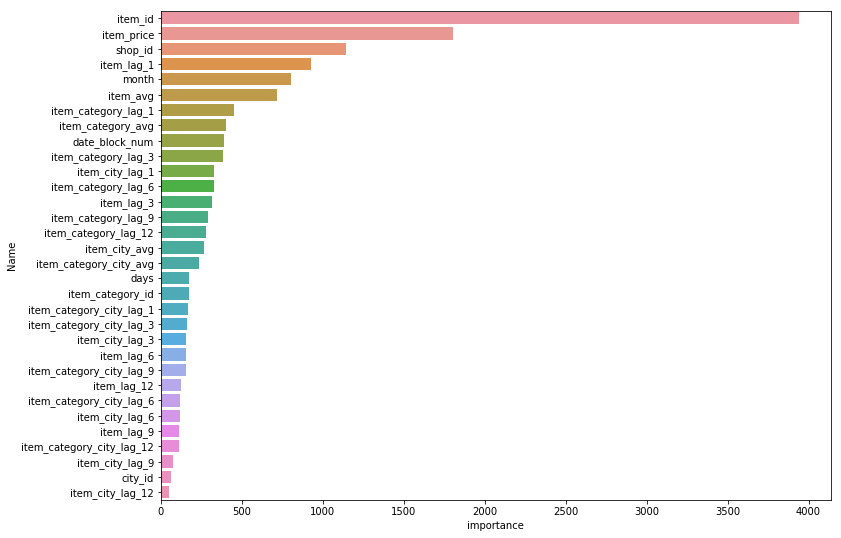

In [24]:
lgbmMetrics = pd.concat([pd.Series(columns), pd.Series(gbm.feature_importance())], axis=1)
lgbmMetrics.columns = ['Name', 'importance']
metrics_sorted = lgbmMetrics.sort_values(by='importance', ascending=False)
g = sns.barplot(x="importance", y="Name", data=metrics_sorted)
g.figure.set_size_inches(12, 9)